# Variational AutoEncoder (VAE)

$\def\abs#1{\left\lvert #1 \right\rvert} \def\Set#1{\left\{ #1 \right\}} \def\mc#1{\mathcal{#1}} \def\M#1{\boldsymbol{#1}} \def\R#1{\mathsf{#1}} \def\RM#1{\boldsymbol{\mathsf{#1}}} \def\op#1{\operatorname{#1}} \def\E{\op{E}} \def\d{\mathrm{\mathstrut d}}$

To do:
- explanation for the trainning and ploting
- the analysis of the two term in the ELBO and relation with Information theory
- infoVAE
- Examples showing why InfoVAE

Notations:  
*When substitue, remember skip the code*
- substitue $Z$ by $\R{Z}$ and similar for $X$
- substitue Encoder by *Encoder*, and similar for decoder

To improve:
- why directly sampling posterior is intractable
- reparameterization trick, seems have relationship with importance sampling
- whether also use sampling for x_hat in the experiment
- where to put the code for importing packages
- should we use capital variable name for batch_size, epochs, etc..
- The train dateset and test dataset maybe combined. Currently, use the train dataset for training, and test dataset for evaluating is a bit improper to see the reconstruction performance.

Remark  
- The following follows the idea from https://arxiv.org/abs/1606.05908 , Tutorial on Variational Autoencoders   

- I skipped the illustration from $p_{\hat{X}|Z}(x|z) = \mc{N}(\mu_{\phi}, \sigma^2 * \M{I})$ to $p_{\hat{X}|Z}(x|z) = \mc{N}(\mu_{\phi}, \Sigma_{\phi})$ 

- About the notation, since the standard Gaussian distribution in latent space is introduced first, $Z$ is the know standard Gaussian distribution, and then $\hat{Z}$ is the representation given by the encoder. the pairs are: $X - (Encoder) - \hat{Z}$, $Z - (Decoder) - \hat{X}$, $\hat{Z} - (Decoder) - \bar{X}$.  
When we consider VIB, we may need the markov chain $Y - X - Z$, where $Z$ is used as the representation of $X$, and if VIB is involved, then introduce $\bar{Z}$ as the know stardard Gaussian distribution is better, and the pairs are: $X - (Encoder) - Z$, $\bar{Z} - (Decoder) - \hat{X}$, $Z - (Decoder) - \bar{X}$.

# Problem formulation


Given a dataset containing samples $\R{X}$.    
How to design a model that with latent random variariable $\R{Z}$ as input, it generate different samples that are like those already in a trainning datase, but not exactly the same?

Suppose a deterministic function $g: \mc{Z} \rightarrow \mc{X}$ parametrized by $\phi$ which models $p_{\hat{X}|Z}$, i.e., outputs the generated samples with input from latent space $\mc{Z}$.  

When $Z$ is random, $g(Z)$ will be a random variable in sample space $\mc{X}$. 
e want to choose the $\phi$ such that by sampling a $z \sim p_{Z}$, $g(z)$ will be like the $x's$ in the dataset with high probability. 

We may try to maximize the probability for generating sample $\hat{X}$ by training the the parameter $\phi$ of function $g$ according to the law of total probability:
$$p_{\hat{X}}(X)=\int p_{\hat{X}|Z}(X|z) p_{Z}(z) dz.$$ 

We assume $p_{Z}$ is a standard Gaussian distribution, and $p_{\hat{X}|Z}(X|z)$ is a Gaussian distribution with mean and variance given by $g(Z)$. This is to say,   
$$Z \sim \mc{N}(\M{0},\M{I}),$$ 
and $$p_{\hat{X}|Z}(x|z) = \mc{N}(x | \mu_{\phi}, \Sigma_{\phi}),$$ 
where 
$$[\mu_{\phi}, \Sigma_{\phi}] = g(z).$$ 

The empiracal way to approximate $p_{\hat{X}}$ is to sammple a large number of $z$ values $\{z_1, z_2, \dots, z_n\}$ from Z followed by computing:
$$p_{\hat{X}}(X) \approx \frac{1}{n} \sum_{i} p_{\hat{X}|Z}(X|z_i)$$

However, this needs too many samples and is intractable.

Then we want to sample the $z$ values that are likely to generate $x$. This means we need inferring $\hat{Z}$ from $X$.

We assume $p_{\hat{Z}|X}(Z|x)$ is a Gaussian distribution, and use a trainable function $f:\mc{X} \rightarrow \mc{Z}$ parameterized by $\theta$ to output the mean and variance of $p_{\hat{Z}|X}(Z|x)$. This is to say
$$ p_{\hat{Z}|X}(z|x) =\mc{N}(z | \mu_{\theta}, \Sigma_{\theta}), $$
where 
$$[\mu_{\theta}, \Sigma_{\theta}] = f(x).$$ 

We have: 
$$ p_{\hat{X}}(x) = \underbrace{E[p_{\hat{X}|Z}(x|\hat{Z})| x=X] -D(P_{\hat{Z}|X}(\cdot | x) || P_{Z})}_{\text{ELBO}(x)} + D(P_{\hat{Z}|X}(\cdot | x) | P_{Z|X}(\cdot | x)).$$

Hence,
$$ E[p_{\hat{X}}(X)] \geq \underbrace{E[p_{\hat{X}|Z}(X|\hat{Z})] - D(P_{\hat{Z}|X} || P_{Z}|P_{X})}_{\text{ELBO}}. $$

Then to maximize $E[p_{\hat{X}}(X)]$, we can optimize the parameters of the whole model by maximizing the ELBO.  

We usually minimizing an objective function, and it is
$$\min_\limits{\phi, \theta} L_{\text{VAE}} := E[ - p_{\hat{X}|Z}(X|\hat{Z})] + D(P_{\hat{Z}|X} || P_{Z}|P_{X})$$

---
**Exercise** 

Prove that 
$$ p_{\hat{X}}(x) \geq E[p_{\hat{X}|Z}(x|\hat{Z})|x=X] -D(P_{\hat{Z}|X}(\cdot | x) || P_{Z}). $$

We use neural networks for $f$ and $g$, and we call $f$ the $Decoder$ and $g$ the $Encoder$, since the structure of the whole model resembles an autoencoder.

Reference  
https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/01_Variational_AutoEncoder.ipynb
https://github.com/AntixK/PyTorch-VAE
https://github.com/GuHongyang/VaDE-pytorch

https://arxiv.org/abs/1606.05908

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

In [2]:
# https://pytorch.org/docs/stable/notes/randomness.html
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

import random
random.seed(SEED)
import datetime

In [3]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 128

x_dim  = 784 # dimension of input data for Decoder
latent_dim = 200 # dimension for latent representation z
hidden_dims = [400] 
decoder_hidden_dims = None # if not None, it means specifying different hidden nodes of internal layers for Decoder with Encoder

beta = 1 # the coefficient for the divergence term in L_{VAE}, beta = 1 is the vanilla VAE

lr = 1e-3

epochs = 15


# Load Dataset

Use MNIST dataset as an example.  

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

# Model

Build the Encoder, i.e., the function $f$, for inferring $\hat{Z}$ from $X$.
$$ p_{\hat{Z}|X}(z|x) =\mc{N}(z | \mu_{\theta}, \Sigma_{\theta}), $$
where 
$$[\mu_{\theta}, \Sigma_{\theta}] = f(x).$$ 

We assume $\Sigma_{\theta}$ is diagonal, i.e.,
$$\Sigma_{\theta} := \text{diag}\left(\left\{\sigma_{\theta, 1}^2, \sigma_{\theta, 2}^2, \dots,  \sigma_{\theta, d_{Z}}^2 \right\}\right) =  \text{diag} \left( \left\{\sigma_{\theta, j}^2 \right\}_{j=1}^{d_{Z}} \right),$$ 
where $d_{Z}$ is the dimension of $Z$.  

The output of the Encoder is $\mu_{\theta}$ and $\left[\log \sigma_{\theta, 1}^2, \log \sigma_{\theta, 2}^2, \dots,  \log \sigma_{\theta, d_{Z}}^2 \right]$

In [5]:
class Encoder(nn.Module):      def __init__(self, x_dim=x_dim, latent_dim=latent_dim, hidden_dims = hidden_dims):
        super(Encoder,self).__init__()

 
        self.x_dim = x_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims       modules = []
              self.input_dim = x_diself.m
   
 or h_dim in hidden_dimsself.:
             modules.append(
                
nn.Sequential(
          
                     n.sLelf.input h_dim)
           ,          nn.ReLU(inplnn.ReLU()               )            )  sel
            finputself._dim = h_dim.encoder=nn.Sequential(
            *blimodules=nn.Linear(inter_dims[-1],hid_dimhidden_dimsself.[-1]. latent_dim_self.z=nn.Linear(inter_dims[-1nn.Linear(hidden_dimsself.[-1], latent_dim)self. x):
        e=self.encoder(x)

        mu=self.mu_z(e)
        log_var=self.log_var_z(e)

        return mu, log_var        

Build the Decoder, i.e., the function $g$, for generating $\hat{X}$ from $Z$.  

$$p_{\hat{X}|Z}(x|z) = \mc{N}(x | \mu_{\phi}, \Sigma_{\phi}),$$ 
where 
$$[\mu_{\phi}, \Sigma_{\phi}] = g(z).$$ 



The default hidden dimensions of the layers in Decoder are the reverse order of those in Encoder.  

We can also define a different one for Decoder by setting the argument *decoder_hidden_dims*.  

In the Decoder here, for an input $z$ we use $\mu_{\phi}$ as $\hat{x}$.

In [6]:
class Decoder(nn.Module):
    def __init__(self, x_dim=x_dim, latent_dim=latent_dim, hidden_dims = hidden_dims, decoder_hidden_dims = decoder_hidden_dims):
        super(Decoder,self).__init__()

        self.x_dim = x_dim
        self.latent_dim = latent_dim
        self.hidden_dims = hidden_dims
        self.decoder_hidden_dims = decoder_hidden_dims

        modules = []

        if self.decoder_hidden_dims is None:
            self.decoder_hidden_dims = list(reversed(self.hidden_dims))

        self.input_dim = self.latent_dim

        for h_dim in self.decoder_hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(self.input_dim, h_dim),
                    nn.ReLU(inplace=True)
                )
            )
            self.input_dim = h_dim

        self.decoder=nn.Sequential(*modules)

        self.mu_x=nn.Linear(self.decoder_hidden_dims[-1], self.x_dim)
        # self.log_var_x=nn.Linear(hidden_dims[-1], self.x_dim)

    def forward(self, z):
        d=self.decoder(z)
        
        # use Sigmoid activation to ensure elements of mu, or the x_hat below are in (0,1)
        mu=torch.sigmoid(self.mu_x(d))
        # log_var=self.log_var_x(d)

        # for decoder, we care about the mean
        x_hat = mu

        return x_hat

# Reparameterization

To train the Encoder and Decoder, we need the gradients with respect to the trainable parameters, and backpropagate through the neural networks.  

However, the input for the Decoder, $\hat{z}$ values is randomly sampled from $\mc{N}(\mu_{\theta}, \Sigma_{\theta})$, and the backpropagation cannot flow through such a random node.  

Instead of directly sampling $\hat{z}$ values the reparameterization trick introduces a random variable $$\epsilon \sim \mc{N}(\M{0},\M{I}),$$ and sample 
$$\epsilon_i \sim \mc{N}(\M{0},\M{I}),$$ then $z_i$ is obtained by 
$$z_i = \mu_{\theta} + \text{diag} \left( \left\{\sigma_{\theta, j} \right\}_{j=1}^{d_{Z}} \right) \cdot \epsilon_i,$$ 
where we assume $\Sigma_{\theta}$ is a diagonal matrix with 
$$\Sigma_{\theta} := \text{diag} \left( \left\{\sigma_{\theta, j}^2 \right\}_{j=1}^{d_{Z}} \right).$$

In [7]:
def reparameterization(mean, std):
    epsilon = torch.randn_like(std).to(DEVICE)        # sampling epsilon        
    z = mean + std*epsilon                          # reparameterization trick
    return z

Build the model composed of Encoder and Decoder

In [8]:
class Model(nn.Module):
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder     
                
    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = reparameterization(mu, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        
        return x_hat, mu, log_var

In [9]:
# encoder = Encoder(input_dim=784,inter_dims=[500,500,2000],hid_dim=10)
# # decoder and encoder are symetric, and for the arguments decides the dimension of each layer we look at the layers of decoder from "tail to head"
# decoder = Decoder(input_dim=784,inter_dims=[500,500,2000],hid_dim=10)

encoder=Encoder()
decoder=Decoder()

model = Model(encoder=encoder, decoder=decoder).to(DEVICE)

# Train the model

In [10]:
from torch.optim import Adam

def loss_function(x, x_hat, mu, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='mean')
    KLD = - 0.5 * torch.mean(1+ log_var - mu ** 2 - log_var.exp())

    return reconstruction_loss + beta * KLD, reconstruction_loss, KLD 

optimizer = Adam(model.parameters(), lr=lr)

In [11]:
print("Start training VAE...")
model.train()

loss_list = []
reconstruction_loss_list = []
KLD_list = []
for epoch in range(epochs):
    overall_loss = 0
    overall_reconstruction_loss = 0
    overall_KLD = 0
    overall_sample_number = 0
    for batch_idx, (x, _) in enumerate(train_loader):

        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mu, log_var = model(x)
        loss, reconstruction_loss, KLD = loss_function(x, x_hat, mu, log_var)
        
        overall_loss += loss.item() * x.shape[0]
        overall_reconstruction_loss += reconstruction_loss.item() * x.shape[0]
        overall_KLD += KLD.item() * x.shape[0]
        overall_sample_number += x.shape[0]

        train_loss = overall_loss / overall_sample_number
        train_reconstruction_loss = overall_reconstruction_loss / overall_sample_number
        train_KLD = overall_KLD / overall_sample_number
        
        loss.backward()
        optimizer.step()

    loss_list.append(train_loss)
    reconstruction_loss_list.append(train_reconstruction_loss)
    KLD_list.append(train_KLD)

    # print(datetime.datetime.now().strftime('%Y-%m-%d  %H:%M:%S'), "\tEpoch", epoch + 1, ":", "\tKLD Loss: ", overall_KLD / overall_sample_number, "\treconstruction Loss: ", overall_reconstruction_loss / overall_sample_number, "\tLoss: ", overall_loss / overall_sample_number)

    print(datetime.datetime.now().strftime('%Y-%m-%d  %H:%M:%S'), " \tEpoch {}: \tKLD Loss: {:.6f} \treconstruction Loss: {:.6f} \tLoss: {:.6f}".format(epoch + 1, train_KLD, train_reconstruction_loss, train_loss))

print("Finish!!")

Start training VAE...
2021-08-18  23:37:51  	Epoch 1: 	KLD Loss: 0.013805 	reconstruction Loss: 0.246022 	Loss: 0.259827
2021-08-18  23:37:59  	Epoch 2: 	KLD Loss: 0.027442 	reconstruction Loss: 0.202921 	Loss: 0.230363
2021-08-18  23:38:06  	Epoch 3: 	KLD Loss: 0.031759 	reconstruction Loss: 0.192983 	Loss: 0.224742
2021-08-18  23:38:14  	Epoch 4: 	KLD Loss: 0.034225 	reconstruction Loss: 0.182276 	Loss: 0.216501
2021-08-18  23:38:21  	Epoch 5: 	KLD Loss: 0.036129 	reconstruction Loss: 0.172537 	Loss: 0.208666
2021-08-18  23:38:29  	Epoch 6: 	KLD Loss: 0.037930 	reconstruction Loss: 0.166025 	Loss: 0.203955
2021-08-18  23:38:37  	Epoch 7: 	KLD Loss: 0.039828 	reconstruction Loss: 0.160631 	Loss: 0.200459
2021-08-18  23:38:44  	Epoch 8: 	KLD Loss: 0.041287 	reconstruction Loss: 0.156627 	Loss: 0.197914
2021-08-18  23:38:52  	Epoch 9: 	KLD Loss: 0.042106 	reconstruction Loss: 0.154321 	Loss: 0.196427
2021-08-18  23:38:59  	Epoch 10: 	KLD Loss: 0.042611 	reconstruction Loss: 0.152774 	Lo

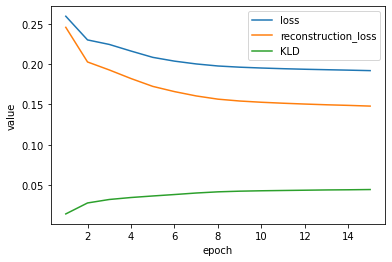

In [12]:
plt.figure()
plt.plot(range(1,epochs+1), loss_list, label = 'loss')
plt.plot(range(1,epochs+1), reconstruction_loss_list, label = 'reconstruction_loss')
plt.plot(range(1,epochs+1), KLD_list, label = 'KLD')
plt.xlabel('epoch')
plt.ylabel('value')
plt.legend()
plt.show()

# Visuallization

You can set the *batch_idx* value, which is the batch we want to evaluate. The evaluating process will stop at the selected batch.

In [13]:
# set the index of the batch you want to evaluate
batch_selected = 0 

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)): # use the test dataset here, but it is only used for comparing original sample and generated sample  
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        if batch_idx == batch_selected:
            break

  0%|          | 0/79 [00:01<?, ?it/s]


In [14]:
# Define the function for ploting
def show_image(x, idx, title=None):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    if title is not None:
        plt.suptitle(title)
    plt.imshow(x[idx].cpu().numpy())

You can set the *idx_selected* value, which is the index of the sample in the above batch we want to evaluate.

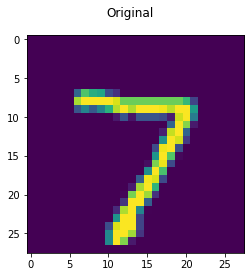

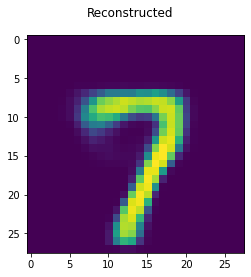

In [15]:
# set the idx_selected to see the image in the batch you want to see
idx_selected = 0

show_image(x, idx=idx_selected, title='Original') 
show_image(x_hat, idx=idx_selected, title='Reconstructed')

You can input a integer in \[0, 9999\] in the *text box*, or drag the *slider bar*, and the value will be the index for the sample which will be shown with title 'orignal image', and the corresponding reconstructed image will also be shwon.  

You might see some images are not reconstructed well.

In [16]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

def plot_x(i):
    model.eval()
    with torch.no_grad():
        x=test_dataset[i][0]
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)

        fig = plt.figure(figsize=(8,8))
        plt.subplot(1,2,1)
        plt.title('Original image')
        plt.imshow(x.view(28,28).cpu().numpy())
        plt.subplot(1,2,2)
        plt.title('reconstructed image')
        plt.imshow(x_hat[0].view(28,28).cpu().numpy())
        # plt.imshow(x_hat[0].view(28,28).cpu().numpy(), cmap="gray")
        plt.show()

widget_a = widgets.BoundedIntText(value=1, min=0, max=9999, step=1)
widget_b = widgets.IntSlider(value=1, min=0, max=9999, step=1)
mylink = widgets.jslink((widget_a, 'value'), (widget_b, 'value'))

display(widget_a)
interact(plot_x, i = widget_b)

BoundedIntText(value=1, max=9999)

interactive(children=(IntSlider(value=1, description='i', max=9999), Output()), _dom_classes=('widget-interact…

<function __main__.plot_x(i)>

Generate samples by randomly sampling $z$ values from $p_{Z}$

In [17]:
model.eval()

with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

save_image(generated_images.view(-1, 1, 28, 28), 'generated_sample.png')

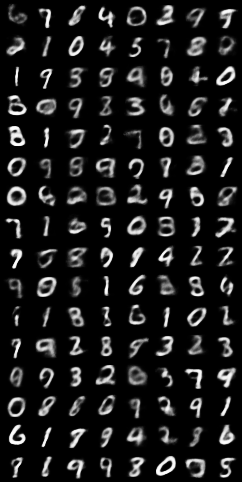

In [18]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename =r"./generated_sample.png")

You can view the single generated image by changing the value of the argument *idx*.  

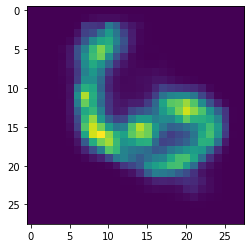

In [19]:
show_image(generated_images, idx=0)

---
**Exercise** 

What is the relationship between the divergence term in $L_{\text{VAE}}$ and $I(\hat{Z}, X)$?  

What will happen if the model is sufficiently flexible and the $L_{\text{VAE}}$ achieves optimal value?


Try use stronger Encoder and Decoder.

# Balancing the two terms in $L_{\text{VAE}}$

Define the loss $L_{\beta}$
$$L_{\beta} := E[ - p_{\hat{X}|Z}(X|\hat{Z})] + \beta D(P_{\hat{Z}|X} || P_{Z}|P_{X}).$$

distanglement and informative

# InfoVAE